## Time-Series Classification

Time series classification arises in many contexts, for example, in activity prediction, we can use multivariate time-series such as heart-rate, step-count, GPS to predict a physical activity such as walking, running, biking, climbing stairs or resting. Our goal is to learn the hidden states from our time-series data based on which we can classify the time-series into one of several categories.

Some of the most popular techniques for time-series classification include Hidden Markov Models, Dynamic Time Warping, Recurrent Neural Networks, Dynamic Bayes Nets, and temporal feature engineering. In this notebook, we are going to use Reccurent Neural Networks (RNNs) to classify a biological time-series consisting of a 5-class ECG data.

We are going to use a stacked LSTM model in order to learn higher-level dependencies present in our time-series data. The idea behind stacking LSTM units is to learn a hierarchical representation of our data. Each LSTM will output a sequence of vectors which will be used as an input to a subsequent LSTMs. This hierarchy of hidden layers will enable more complex representation of our time-series data, capturing information at different scales.

We are going to use Keras on top of TensorFlow to implement our time-series classifier.

In [22]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

The ECG5000 dataset can be downloaded from http://www.cs.ucr.edu/~eamonn/time_series_data/

In [2]:
DATA_PATH = '/data/vision/fisher/data1/vsmolyakov/time_series/ECG5000/'

#load data
train_df = pd.read_csv(DATA_PATH + "/ECG5000_TRAIN")  
test_df = pd.read_csv(DATA_PATH + "/ECG5000_TEST")

X_train, y_train = train_df.iloc[:,1:].values, train_df.iloc[:,0].values
X_test, y_test = test_df.iloc[:,1:].values, test_df.iloc[:,0].values

Let's visualize the first 1024 points of ECG time-series.

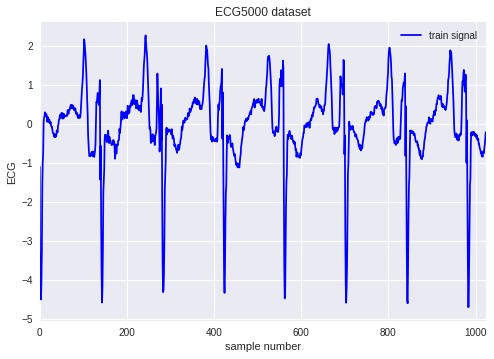

In [3]:
#visualize data
X_vis = np.squeeze(X_train.reshape(1, X_train.size))
plt.figure()
plt.plot(range(1024), X_vis[:1024], color='blue', label='train signal')
plt.title('ECG5000 dataset')
plt.xlabel('sample number')
plt.ylabel('ECG')
plt.legend()
plt.xlim([0, 1024])
plt.show()

Due to the regularity in our data, we are going to use stateful LSTMs, which means that latent states for the sample of each batch will be used as initial states for the samples in the next batch. For stateful LSTMs, we need to make sure that the number of training examples is evenly divisible into the number of batches. In addition, we will reshape our data into the input shape expected by LSTM: (batch_size, time_steps, data_dimension) and convert our class label using one-hot encoding.

In [4]:
#prepare data
batch_size = 32
num_epochs = 128

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

num_classes = len(set(y_train).union(set(y_test)))
y_train = to_categorical(y_train-1, num_classes=num_classes) 
y_test = to_categorical(y_test-1, num_classes=num_classes)

#for stateful LSTMs, need fixed size batches
num_batches = np.int(X_train.shape[0]/batch_size)
X_train = X_train[0:num_batches*batch_size,:,:]
X_test = X_test[0:num_batches*batch_size,:,:]

y_train = y_train[0:num_batches*batch_size]
y_test = y_test[0:num_batches*batch_size]

We'll use a three-layer stacked LSTM with 64 cells and Adam optimizer with initial learning rate of 0.001

In [5]:
#define the model 
#input shape: (batch_size, time_steps, data_dimension)

model = Sequential()
model.add(LSTM(64, return_sequences=True, stateful=True, 
               batch_input_shape=(batch_size, 1, X_train.shape[-1])))
model.add(LSTM(64, return_sequences=True, stateful=True))
model.add(LSTM(64, stateful=True))
model.add(Dense(num_classes, activation='softmax'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

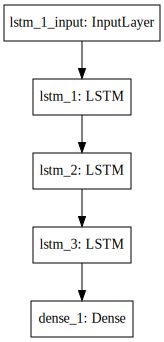

In [23]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

We are going to define a number of callbacks to monitor quantities of interest during training. In particular, we'll define a checkpoint to save model weights upon loss improvement, we will also monitor our training loss using tensorboard. We'll reduce our learning rate by a factor of 10 once we hit a plateau in our loss and we'll use early stopping to limit the number of training epochs in case there's no improvement in the loss.

In [6]:
#define callbacks
file_name = DATA_PATH + 'weights-checkpoint.hdf5'
checkpoint = ModelCheckpoint(file_name, monitor='loss', verbose=1, save_best_only=True, mode='min')
tensor_board = TensorBoard(log_dir='./logs', write_graph=False, write_images=False)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=8, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=16, verbose=1)
callbacks_list = [checkpoint, tensor_board, reduce_lr, early_stopping]

In [7]:
#model training
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,
                 shuffle=False, callbacks=callbacks_list, verbose=2)

model.save(DATA_PATH + 'final_model.h5', overwrite=True)
model.save_weights(DATA_PATH + 'final_weights.h5',overwrite=True)


Epoch 1/128
Epoch 00000: loss improved from inf to 1.76002, saving model to /data/vision/fisher/data1/vsmolyakov/time_series/ECG5000/weights-checkpoint.hdf5
0s - loss: 1.7600 - acc: 0.5500
Epoch 2/128
Epoch 00001: loss improved from 1.76002 to 0.75364, saving model to /data/vision/fisher/data1/vsmolyakov/time_series/ECG5000/weights-checkpoint.hdf5
0s - loss: 0.7536 - acc: 0.6062
Epoch 3/128
Epoch 00002: loss did not improve
0s - loss: 0.8621 - acc: 0.3771
Epoch 4/128
Epoch 00003: loss did not improve
0s - loss: 0.8816 - acc: 0.5000
Epoch 5/128
Epoch 00004: loss did not improve
0s - loss: 0.7868 - acc: 0.6021
Epoch 6/128
Epoch 00005: loss improved from 0.75364 to 0.74336, saving model to /data/vision/fisher/data1/vsmolyakov/time_series/ECG5000/weights-checkpoint.hdf5
0s - loss: 0.7434 - acc: 0.6354
Epoch 7/128
Epoch 00006: loss improved from 0.74336 to 0.70966, saving model to /data/vision/fisher/data1/vsmolyakov/time_series/ECG5000/weights-checkpoint.hdf5
0s - loss: 0.7097 - acc: 0.654

0s - loss: 0.0425 - acc: 0.9938
Epoch 52/128
Epoch 00051: loss did not improve
0s - loss: 0.0445 - acc: 0.9833
Epoch 53/128
Epoch 00052: loss improved from 0.04245 to 0.04077, saving model to /data/vision/fisher/data1/vsmolyakov/time_series/ECG5000/weights-checkpoint.hdf5
0s - loss: 0.0408 - acc: 0.9938
Epoch 54/128
Epoch 00053: loss improved from 0.04077 to 0.03961, saving model to /data/vision/fisher/data1/vsmolyakov/time_series/ECG5000/weights-checkpoint.hdf5
0s - loss: 0.0396 - acc: 0.9938
Epoch 55/128
Epoch 00054: loss improved from 0.03961 to 0.03794, saving model to /data/vision/fisher/data1/vsmolyakov/time_series/ECG5000/weights-checkpoint.hdf5
0s - loss: 0.0379 - acc: 0.9938
Epoch 56/128
Epoch 00055: loss improved from 0.03794 to 0.03763, saving model to /data/vision/fisher/data1/vsmolyakov/time_series/ECG5000/weights-checkpoint.hdf5
0s - loss: 0.0376 - acc: 0.9938
Epoch 57/128
Epoch 00056: loss improved from 0.03763 to 0.03700, saving model to /data/vision/fisher/data1/vsmoly

Let's evaluate our model on the test set:

In [13]:
#model evaluation
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print "\ntest loss: ", test_loss
print "test accuracy: ", test_acc

 32/480 [=>............................] - ETA: 0s
test loss:  0.00193859708185
test accuracy:  1.0


We did pretty well on the test set, achieving an accuracy of 1!

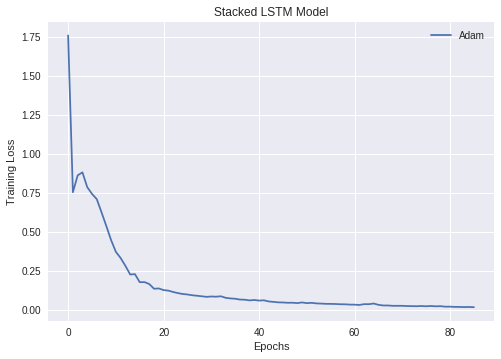

In [15]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], label='Adam')
plt.title('Stacked LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.savefig('./figures/stacked_lstm_training_loss.png')
plt.show()

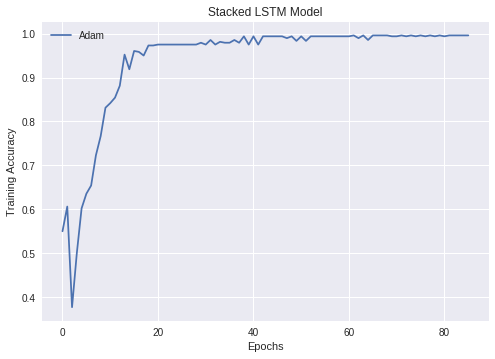

In [16]:
plt.figure()
plt.plot(hist.history['acc'], label='Adam')
plt.title('Stacked LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.savefig('./figures/stacked_lstm_training_acc.png')
plt.show()

In [17]:
plot_model(model, to_file='./figures/stacked_lstm_model.png')

From the loss and accuracy plots we can see that early stopping limited the number of epochs to 85 which is when our objective stopped improving. In addition, we can use tensorboard to visualize our training loss and accuracy plots by executing "tensorboard --logdir=./logs/" in the terminal.